In [1]:

#  install torch_geometric packages

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 18.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 25.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00


In [3]:
%cd ..

D:\ai\GNN


C:\Users\kkire\anaconda3\envs\dl\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
%ls 

 Volume in drive D is DATA
 Volume Serial Number is 4096-85EF

 Directory of D:\ai\GNN

10-06-2024  12:18    <DIR>          .
07-06-2024  23:38    <DIR>          ..
23-06-2024  23:01    <DIR>          experiments
08-06-2024  18:03                 0 main.py
08-06-2024  18:11    <DIR>          models
23-06-2024  21:55            11,344 reqirements.txt
10-06-2024  22:26    <DIR>          utils
               2 File(s)         11,344 bytes
               5 Dir(s)  972,973,948,928 bytes free


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, Linear
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

from models.model import GNN, GCN
from models.layers import gLayer, gConv, ChebConv
from utils.train import get_params, train,eval, run_experiment

import time
from scipy import stats
import numpy as np
import random
import networkx as nx
import pandas as pd
from tqdm import tqdm
import os

In [6]:
clear = os.system('cls')

In [6]:
def hamiltonian_cycle_dynamic_programming(G):
    """
    Dynamic programming algorithm to decide if a Hamiltonian cycle exists in a graph.

    Parameters:
    - G: NetworkX graph

    Returns:
    - A Hamiltonian cycle as a list of nodes if it exists, otherwise None
    """
    n = len(G.nodes())
    nodes = list(G.nodes())
    index = {nodes[i]: i for i in range(n)}

    # dp[mask][i] will be True if there is a Hamiltonian path that visits all nodes in mask, ending at node i
    dp = [[False] * n for _ in range(1 << n)]
    dp[1][0] = True  # Starting at node 0

    # Iterate over all subsets of nodes
    for mask in range(1 << n):
        for u in range(n):
            if dp[mask][u]:  # If there's a Hamiltonian path for this subset ending at u
                for v in range(n):
                    if mask & (1 << v) == 0 and G.has_edge(nodes[u], nodes[v]):
                        dp[mask | (1 << v)][v] = True

    # Check if there's a Hamiltonian cycle
    final_mask = (1 << n) - 1  # All nodes are visited
    for u in range(1, n):
        if dp[final_mask][u] and G.has_edge(nodes[u], nodes[0]):
            # Reconstruct the path
            path = [0]
            mask = final_mask
            last = u
            while mask != 1:
                for v in range(n):
                    if mask & (1 << v) and dp[mask ^ (1 << last)][v] and G.has_edge(nodes[v], nodes[last]):
                        path.append(last)
                        mask ^= (1 << last)
                        last = v
                        break
            path.append(0)
            path.reverse()
            return True
    return False

In [7]:
def create_hamiltonian_cycle_graph(n):
    """
    Creates a graph with a known Hamiltonian cycle.
    Parameters:
    - n: number of nodes in the graph
    Returns:
    - G: NetworkX graph with a Hamiltonian cycle
    """
    # Create a cycle graph with n nodes
    G = nx.cycle_graph(n)

    # Optionally, add some random edges to make the graph more complex
    # Ensure the added edges do not disrupt the Hamiltonian cycle

    num_additional_edges = random.randint(0, n * (n - 1) // 2 - n)  # Add additional edges

    possible_edges = list(nx.complement(G).edges())
    random.shuffle(possible_edges)
    additional_edges = possible_edges[:num_additional_edges]
    G.add_edges_from(additional_edges)

    return G

In [8]:
def create_random_graph_without_hamiltonian_cycle(n1, n2):
    """
    Creates a bipartite graph with n1 and n2 nodes in each partition that does not have a Hamiltonian cycle.

    Parameters:
    - n1: number of nodes in the first partition
    - n2: number of nodes in the second partition

    Returns:
    - G: NetworkX bipartite graph without a Hamiltonian cycle
    """
    if abs(n1 - n2) != 1:
        raise ValueError("For the bipartite graph to guarantee no Hamiltonian cycle, partitions should differ by 1.")

    G = nx.complete_bipartite_graph(n1, n2)
    return G

In [9]:
def create_graph_dataset(num_samples, edge_dim, batch_size, split=(0.7, 0.9)):

    data_list = []

    for i in tqdm(range(num_samples)):
        n = random.randint(3, 15)
        t = random.random()
        t2 = random.random()

        if t <0.5:
            G = create_hamiltonian_cycle_graph(n)
        else:
            if t2 < 0.5:
                if n%2 == 0:
                    n -= 1
                k1, k2 = (n+1)//2, (n-1)//2

                G = create_random_graph_without_hamiltonian_cycle(k1, k2)
            else:
                p = (stats.norm.cdf(random.gauss(0, 1)))*(0.71)
                G = nx.gnp_random_graph(n, p)

        x = torch.zeros((n, 1))
        edge_index = [[], []]
        edge_attr = []

        for u, v in G.edges:
            x[u] += 1
            x[v] += 1
            edge_index[0].append(u)
            edge_index[1].append(v)
            edge_attr.append(torch.randn(edge_dim))

        if t < 0.5 or (t>=0.5 and hamiltonian_cycle_dynamic_programming(G)):
            y = 1
        else:
            y = 0

        for i in range(n):
            if x[i] == 0:
                edge_index[0].append(i)
                edge_index[1].append(i)
                edge_attr.append(torch.Tensor(np.random.standard_cauchy(edge_dim)))

        edge_index = torch.Tensor(edge_index).type(torch.LongTensor)
        edge_attr = torch.stack(edge_attr)

        d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data_list.append(d)

    random.shuffle(data_list)

    train_dataset, val_dataset, test_dataset = data_list[:int(num_samples*split[0])], data_list[int(num_samples*split[0]):int(num_samples*split[1])], data_list[int(num_samples*split[1]):]

    train_loader, val_loader, test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [10]:
def check_dataset_balance(dataloader, n_classes, batch_size):

    classes = [0 for _ in range(len(n_classes))]

    print("checking skewing of dataset")

    for d in tqdm(dataloader) :
        for i in range(min(len(d), batch_size)):
            classes[d[i].y] += 1

    print("the dataset contains:")

    for j in range(len(classes)):
        print(f"{classes[j]} instances of {n_classes[j]}")


In [17]:
batch_size=16
edge_dim = 4
num_samples = 10000

class_desc = {0:"hamiltonian cycle", 1:"no hamiltonian cycle"}

print(f"creating dataset containing {num_samples} graphs and batch size of {batch_size}")
train_loader, val_loader, test_loader = create_graph_dataset(num_samples, edge_dim, batch_size)


creating dataset containing 10000 graphs and batch size of 16


100%|██████████| 10000/10000 [02:27<00:00, 67.98it/s]


In [18]:
# print("checking the balance of classes in dataset")
check_dataset_balance(train_loader, class_desc, batch_size)

checking skewing of dataset


100%|██████████| 438/438 [00:01<00:00, 310.72it/s]

the dataset contains:
2833 instances of hamiltonian cycle
4167 instances of no hamiltonian cycle


In [ ]:
'''
PROBLEMs

GNNs by torch_geometric uses the scatter function which calculates the messages given by using the edge_index[1] but this causes problem as edge_index might not contain some edges does to isolated nodes
added self loops to isolated edges and the edge attr of these self loops is sampled from standard_cauchy which is highly different from normal distribution

Solved this by using self loop for isolated edges the edge attributes of these self loops shoukd be different from that of regular edge attributes 

regular edges - gaussian distribution
self loop edges - standard cauchy distribution 

for directed edges:
doing this worked but other methods include not including self loops instead altering the functionality of aggregate function such that nodes that recieve
information will as usual receive messga ebut those which have no incomming edges will not recieve any messages but instead we can use a seperate mlp to process
the embedding vector of these nodes and update their node embeddings that way {{ encouraged to think of a new method }}

for this dataset even though it is an undirected dataset while creating the edge_index I didn't consider it, but it still produced good results

creation of more diverse dataset is crucial as due to computational constraints it is harder for me to create a dataset having more than 20 nodes and also 
it is recommened to use a different method to cretae non hailtonian graphs

'''

In [14]:
sanity_model = GNN(4, 50, 4, 1, 2)
print(sanity_model)

GNN(
  (lin_in): Linear(in_features=1, out_features=50, bias=True)
  (convs): ModuleList(
    (0-3): 4 x gLayer(emb_dim=50, aggr=add)
  )
  (lin_pred): Linear(in_features=50, out_features=2, bias=True)
)


In [15]:
ll = nn.CrossEntropyLoss()

In [21]:
a = torch.Tensor([[0.2356, -1.3686]])
b = torch.Tensor([1]).type(torch.long)
print(ll(a, b))

tensor(1.7874)


In [22]:
print(F.softmax(a, dim=1))

tensor([[0.8326, 0.1674]])


In [16]:

with torch.no_grad():

    for d in val_loader:
        # dd = d[0]
        print(d)
        y_pr = sanity_model(d)
        # print(dd)
        print(y_pr)
        print(d.y)
        print(ll(y_pr, d.y))
        break


DataBatch(x=[36, 1], edge_index=[2, 106], edge_attr=[106, 4], y=[4], batch=[36], ptr=[5])
tensor([[ 0.2356, -1.3686],
        [ 0.0730, -1.6184],
        [ 0.6304, -0.6409],
        [ 0.6203, -1.0323]])
tensor([1, 1, 0, 0])
tensor(1.0176)


In [23]:
print(torch.cuda.is_available())

True


In [24]:
n_layers = 4
emb_dim = 50
in_dim = 1    # in_dim = 1 as the nodes are portraied as (n, 1) the embedding describes the degree of that node
out_dim = len(class_desc)
epochs = 100

model = GNN(n_layers=n_layers, emb_dim=emb_dim, in_dim=in_dim, out_dim=out_dim)
print(type(model).__name__)
print()
print(model)
print(f'Total parameters: {get_params(model)}')

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LR scheduler which decays LR when validation metric doesn't improve
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

model_name = type(model).__name__

best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    epochs,
    loss_func,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    test_loader,
)


GNN

GNN(
  (lin_in): Linear(in_features=1, out_features=50, bias=True)
  (convs): ModuleList(
    (0-3): 4 x gLayer(emb_dim=50, aggr=add)
  )
  (lin_pred): Linear(in_features=50, out_features=2, bias=True)
)
Total parameters: 63402
Running experiment for GNN, training on 7000 samples for 100 epochs.

Model architecture:
GNN(
  (lin_in): Linear(in_features=1, out_features=50, bias=True)
  (convs): ModuleList(
    (0-3): 4 x gLayer(emb_dim=50, aggr=add)
  )
  (lin_pred): Linear(in_features=50, out_features=2, bias=True)
)
Total parameters: 63402

Start training:


 10%|█         | 10/100 [01:01<09:21,  6.24s/it]

Epoch: 010, LR: 0.001000, Loss: 0.0023988, Val Loss: 0.0019298, Test Loss: 0.0010906


 20%|██        | 20/100 [02:00<07:54,  5.94s/it]

Epoch: 020, LR: 0.001000, Loss: 0.0022483, Val Loss: 0.0011539, Test Loss: 0.0054932


 30%|███       | 30/100 [03:01<07:00,  6.00s/it]

Epoch: 030, LR: 0.001000, Loss: 0.0009778, Val Loss: 0.0009333, Test Loss: 0.0007042


 40%|████      | 40/100 [04:02<06:12,  6.21s/it]

Epoch: 040, LR: 0.001000, Loss: 0.0013589, Val Loss: 0.0008006, Test Loss: 0.0007042


 50%|█████     | 50/100 [05:02<04:53,  5.86s/it]

Epoch: 050, LR: 0.001000, Loss: 0.0009694, Val Loss: 0.0008396, Test Loss: 0.0005906


 60%|██████    | 60/100 [06:01<03:53,  5.84s/it]

Epoch: 060, LR: 0.001000, Loss: 0.0016721, Val Loss: 0.0010573, Test Loss: 0.0005906


 70%|███████   | 70/100 [07:02<03:02,  6.09s/it]

Epoch: 070, LR: 0.001000, Loss: 0.0006076, Val Loss: 0.0007931, Test Loss: 0.0005746


 80%|████████  | 80/100 [08:02<02:07,  6.37s/it]

Epoch: 080, LR: 0.001000, Loss: 0.0006809, Val Loss: 0.0006467, Test Loss: 0.0005704


 90%|█████████ | 90/100 [09:03<00:59,  5.97s/it]

Epoch: 090, LR: 0.001000, Loss: 0.0004502, Val Loss: 0.0007316, Test Loss: 0.0006447


100%|██████████| 100/100 [10:03<00:00,  6.03s/it]

Epoch: 100, LR: 0.001000, Loss: 0.0007518, Val Loss: 0.0007550, Test Loss: 0.0006447

Done! Training took 10.05 mins. Best validation Loss: 0.0005117, corresponding test Loss: 0.0006447.


AttributeError: 'DataFrame' object has no attribute 'append'

In [34]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Loss", "Test LOSS", "Val LOSS", "Epoch", "Model"])

In [35]:
DF_RESULTS.head()

,Loss,Test LOSS,Val LOSS,Epoch,Model


In [37]:
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Loss", "Test LOSS", "Val LOSS", "Epoch", "Model"])

In [38]:
print(RESULTS)
df_temp

{'GNN': (0.0005116857351540602, 0.0006446597248268518, 10.054782776037852)}


,Loss,Test LOSS,Val LOSS,Epoch,Model
0,0.009209,0.006775,0.007419,1,GNN
1,0.004902,0.002467,0.003181,2,GNN
2,0.004174,0.002495,0.002876,3,GNN
3,0.003584,0.002495,0.003005,4,GNN
4,0.003345,0.002495,0.002936,5,GNN
...,...,...,...,...,...
95,0.001061,0.000645,0.000615,96,GNN
96,0.000414,0.000645,0.001192,97,GNN
97,0.000437,0.000645,0.001394,98,GNN
98,0.000297,0.000645,0.000589,99,GNN


In [39]:
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)
DF_RESULTS

,Loss,Test LOSS,Val LOSS,Epoch,Model
0,0.009209,0.006775,0.007419,1,GNN
1,0.004902,0.002467,0.003181,2,GNN
2,0.004174,0.002495,0.002876,3,GNN
3,0.003584,0.002495,0.003005,4,GNN
4,0.003345,0.002495,0.002936,5,GNN
...,...,...,...,...,...
95,0.001061,0.000645,0.000615,96,GNN
96,0.000414,0.000645,0.001192,97,GNN
97,0.000437,0.000645,0.001394,98,GNN
98,0.000297,0.000645,0.000589,99,GNN


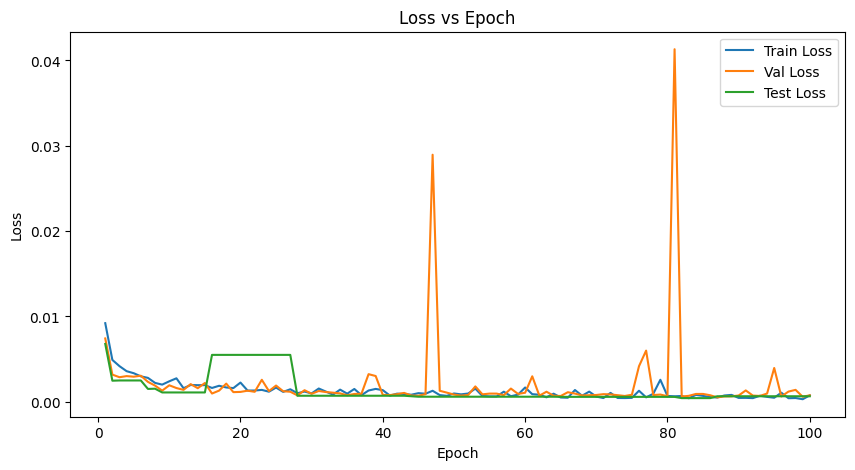

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(DF_RESULTS["Epoch"], DF_RESULTS["Loss"], label="Train Loss")
plt.plot(DF_RESULTS["Epoch"], DF_RESULTS["Val LOSS"], label="Val Loss")
plt.plot(DF_RESULTS["Epoch"], DF_RESULTS["Test LOSS"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()
plt.savefig("/content/HAMD_100epochs.png")

In [60]:
import json

DF_RESULTS.to_csv("HAMD_RESULTS.csv")

with open('HAMD_RESULT.json', 'w') as fp:
    json.dump(RESULTS, fp)

In [56]:
def predict(model, data):
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits, dim=1)
        return torch.argmax(probs, dim=1)

In [57]:
for d in test_loader:
    d = d.to('cuda:0')
    print(predict(model, d))
    print(d.y)
    break

tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')


In [76]:
def compare(model, model_name, func, func_name, data, graph):

    model_time = 0
    func_time = 0

    with torch.no_grad():

        start = time.time()
        prediction = torch.argmax(F.softmax(model(data), dim=1), dim=1)
        model_time = time.time() - start

    start = time.time()
    prediction_func = func(graph)
    func_time = time.time() - start

    return model_time, func_time, prediction, prediction_func

edges: 90
predicted that graph has hamiltonian cycle: False
comparing times of GNN model and dp function:
model name: GNN model_time: 0.004485s model_prediction :tensor([0], device='cuda:0')
function name: dp function time: 4.087114s function_prediction :False


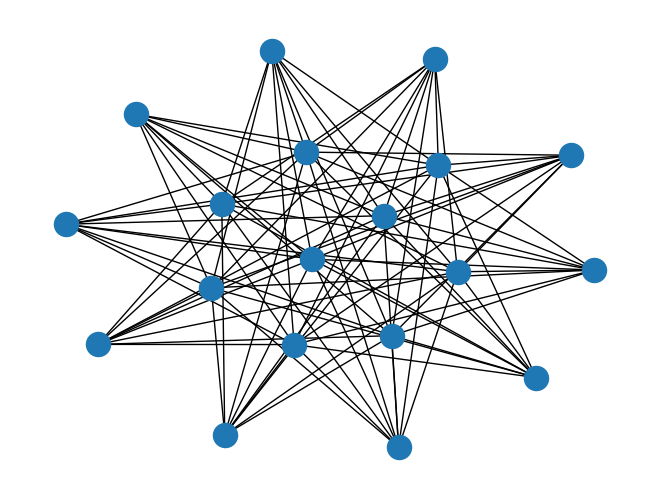

In [81]:
n = 19
if n%2 == 0:
    n -= 1
k1, k2 = (n+1)//2, (n-1)//2

G = create_random_graph_without_hamiltonian_cycle(k1, k2)
print("edges:", len(G.edges))
x = torch.zeros((n, 1))
edge_index = [[], []]
edge_attr = []

for u, v in G.edges:
    x[u] += 1
    x[v] += 1
    edge_index[0].append(u)
    edge_index[1].append(v)
    edge_attr.append(torch.randn(edge_dim))

for i in range(n):
    if x[i] == 0:
        edge_index[0].append(i)
        edge_index[1].append(i)
        edge_attr.append(torch.Tensor(np.random.standard_cauchy(edge_dim)))

edge_index = torch.Tensor(edge_index).type(torch.LongTensor)
edge_attr = torch.stack(edge_attr)

d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=1)
d = d.to('cuda:0')
nx.draw(G)
print("predicted that graph has hamiltonian cycle:", True if predict(model, d).item() == 1 else False)

print(f"comparing times of {model_name} model and dp function:")

model_time, func_time, prediction, prediction_func = compare(model, model_name, hamiltonian_cycle_dynamic_programming, "dp", d, G)
print(f"model name: {model_name} model_time: {model_time:.6f}s model_prediction :{prediction}")
print(f"function name: dp function time: {func_time:.6f}s function_prediction :{prediction_func}")

In [ ]:
model_save_path = "GNN_HAMD.pth"

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

# model_load_path = "GNN_HAMD.pth"

# model.load_state_dict(torch.load(model_load_path))

# print(f"Model loaded from {model_load_path}")

In [ ]:
data_list = []

data_list.extend(train_loader)
data_list.extend(val_loader)
data_list.extend(test_loader)

save_path = 'HAMD_data.pth'

# Save the list of Data objects
torch.save(data_list, save_path)

print(f"Dataset saved to {save_path}")

# load_path = 'path/to/dataset.pth'

# # Load the list of Data objects
# loaded_data_list = torch.load(load_path)

# print(f"Dataset loaded from {load_path}")


In [ ]:
'''
Testing out Convolutions working
'''

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
train_loader, val_loader, test_loader = create_graph_dataset(100, 4, 4)

100%|█████| 100/100 [00:00<00:00, 100.06it/s]


In [12]:
for d in val_loader:
    print(d)
    break

DataBatch(x=[31, 1], edge_index=[2, 86], edge_attr=[86, 4], y=[4], batch=[31], ptr=[5])


In [16]:
from torch_geometric.nn import Linear
lin_in = Linear(1, 32, bias=False)
convolution = gConv(32, 64)


In [22]:
for d in val_loader:
    x, edge_index, edge_attr = d.x, d.edge_index, d.edge_attr
    x = lin_in(x)
    out = convolution(x, edge_index)
    print(x.shape, out.shape, out)
    break

torch.Size([35, 32]) torch.Size([35, 64]) tensor([[0.4973, 0.0000, 0.4604,  ..., 0.0000, 0.6004, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6003, 0.0000, 0.5557,  ..., 0.0000, 0.7248, 0.0000],
        ...,
        [0.9946, 0.0000, 0.9208,  ..., 0.0000, 1.2009, 0.0000],
        [0.9946, 0.0000, 0.9208,  ..., 0.0000, 1.2009, 0.0000],
        [1.3119, 0.0000, 1.2144,  ..., 0.0000, 1.5839, 0.0000]],
       grad_fn=<AddBackward0>)


In [21]:
gcn_model = GCN([16, 32, 64, 128, 128], 50, 1, 2) 
print(gcn_model)

GCN(
  (convs): ModuleList(
    (0-3): 4 x gConv()
  )
  (activation): ReLU()
  (lin_in): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=16, bias=True)
    (3): ReLU()
  )
  (lin_pred): Linear(in_features=128, out_features=2, bias=True)
)


In [18]:
get_params(gcn_model)

28862

In [36]:
get_params(convolution)

2112

In [22]:
for d in val_loader:
    out = gcn_model(d)
    print(out.shape)
    break

torch.Size([4, 2])


In [33]:
a, b = torch.randn(16, 50), torch.randn(16, 50)
y = a+b
print(y.shape)

torch.Size([16, 50])
